# In this notebook I compute the correlation function of the $D_{ls}$ and  $\textit{pseudo} D_{ls}$. The CAMB correlation function are required in both cases

Firs, I need compute the $C_{ls}$ (really $[Cl*l*(l+1)/2/\pi]*[(10⁶)²] = Dl$) to input in camb correlations function. CMB maps are required in all cases. I will take for full sky map a COM_CMB_IQU-smica_2048_R3.00_hm2 cmb map (https://pla.esac.esa.int/), a cut sky with mask where put 0 in contamination regions and 1 and the others. The correlatión function will be bounded with the dispertion of the synthetic cmb maps made by healpy using camb'Dls

1.$\textbf{I compute and plot the correlations functions of the CMB of  using \Lambda CDM parameters (Planck colaboration 2018).
For this propose I use the python library CAMB(Lewis et al. 2016)}.$

In [1]:
# Importing libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

In [2]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower, correlations
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.5 installed at /home/akozameh/miniconda3/envs/CMB2023/lib/python3.10/site-packages/camb


In [3]:
#Calculate results for specified parameters and return CAMBdata instance for getting results.
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933, mnu=0.06, omk=0.001, tau=0.0561)
pars.InitPower.set_params(As=2.105e-9, ns=0.9665, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [4]:
#calculate results for these parameters
results = camb.get_results(pars)

In [5]:
#Set all CAMB parameters at once, including parameters which are part of the CAMBparams structure, as well as global parameters.
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [6]:
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])

(2551, 4)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

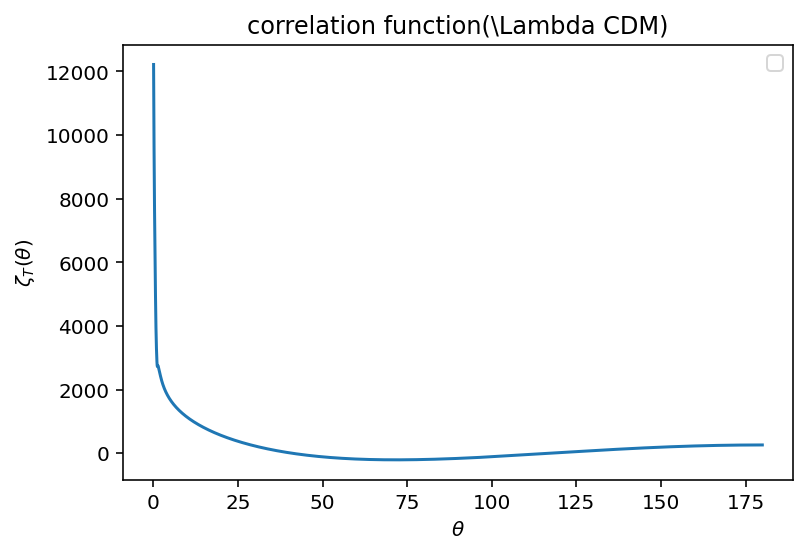

In [158]:
# YI use CAMB to calculate CMB correlation functions
corrs, xvalss, weightss = correlations.gauss_legendre_correlation(totCL)
#xvals=np.linspace(-1,1,2551)
rk=np.arccos(xvalss)*180/np.pi # sampled theta values in degrees
plt.plot(rk, corrs[:,0])
plt.ylabel(r'$\zeta_{T}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.title('correlation function(\Lambda CDM)')
plt.show



2. $\textbf{We used several data products from the Planck 2018
data release.1 We used the Planck SMICA component
separation maps, both full mission and half mission
(HM) maps2
, in our analyses.\\
I  download the COM_CMB_IQU-smica_2048_R3.00_hm2 CMB map (https://pla.esac.esa.int/) and with the help of healpix I will compute.\\
\\the power spectrum of the CMB. Then with CAMB I will compute the correlations function.}$

In [8]:
# import healpy
import healpy as hp

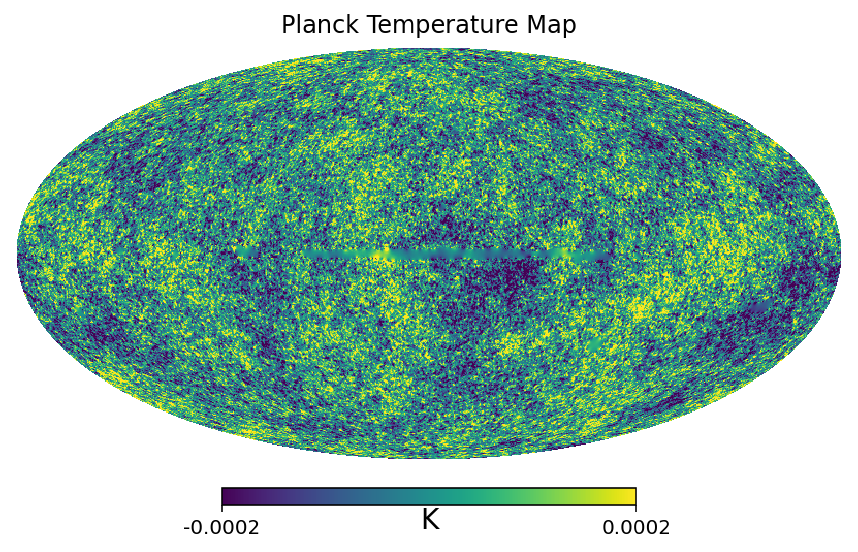

In [10]:
planck_IQU_SMICA=hp.read_map('/home/akozameh/COM_CMB_IQU-smica_2048_R3.00_hm2.fits')
fig=plt.figure(1)
hp.mollview(planck_IQU_SMICA, min=-0.0002,max=0.0002,
title='Planck Temperature Map',fig=1,unit='K')

Compute the $C_{ls}$ with anafast healpy routine

In [11]:
nside = 2048
lmax=2500
Cl = hp.anafast(planck_IQU_SMICA, lmax= lmax)
l=np.arange(len(Cl))

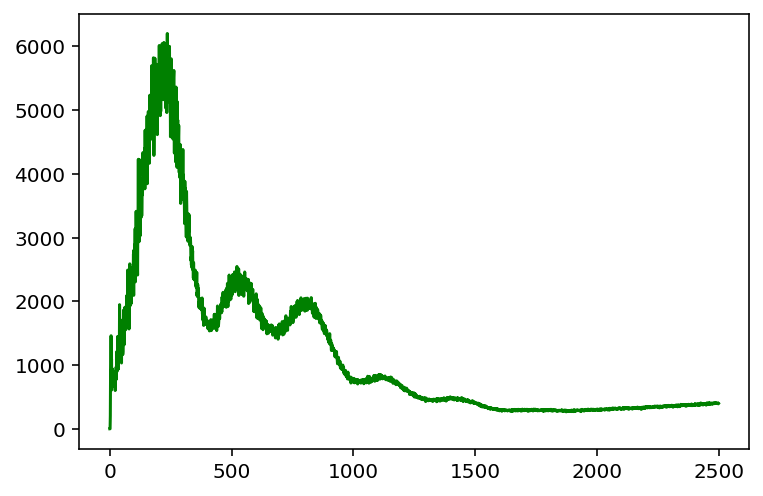

In [12]:
Dl=Cl*l*(l+1)*(1e12)/2/np.pi
plt.plot(l, Dl, color='g')

Compute the correlation function $\zeta_{T1}(\theta)$'

First I must make an arry with dimension four columns

In [13]:
D_l=np.zeros((len(Dl),4))
D_l[:,0]=Dl
D_l.shape

(2501, 4)

In [160]:

corr1, xvals, weights = correlations.gauss_legendre_correlation(D_l) 
#xvals1=np.linspace(-1,1,2501)
r1=np.arccos(xvals)*180/np.pi # sampled theta values in degrees

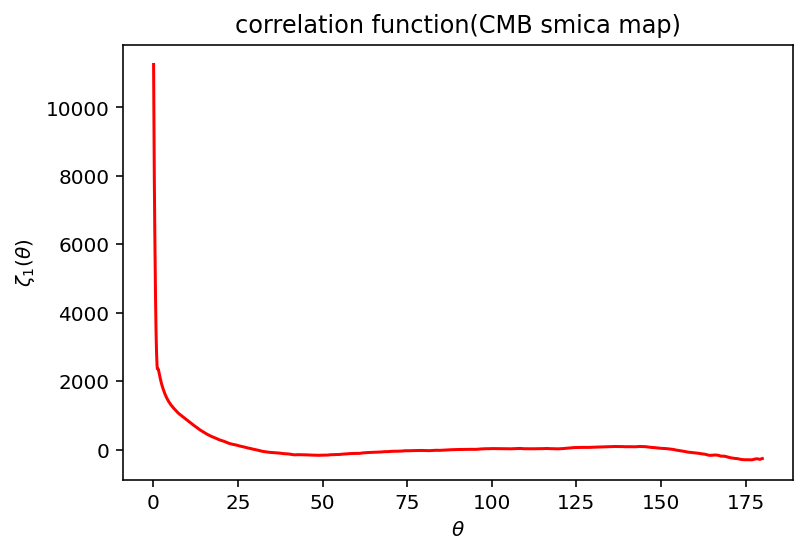

In [161]:
plt.plot(r1, corr1[:,0], color = 'r')
plt.ylabel(r'$\zeta_{1}(\theta)$')
plt.xlabel(r'$\theta$')
#plt.legend()
plt.title('correlation function(CMB smica map)')
plt.show()


3. $$\textbf{Because the residual contaminations of the milky way and dust we can't mesaure in that regions. Then we put a mask with 0 and 1. I compute the \textit{pseudo} $C_{ls}$ with namaster python routine.}$$

In [16]:
#import pymaster
import pymaster as nmt

We downloaded the COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits -- Temperature confidence mask with fsky = 77.9%.

In [17]:
mask=hp.read_map('/home/akozameh/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')

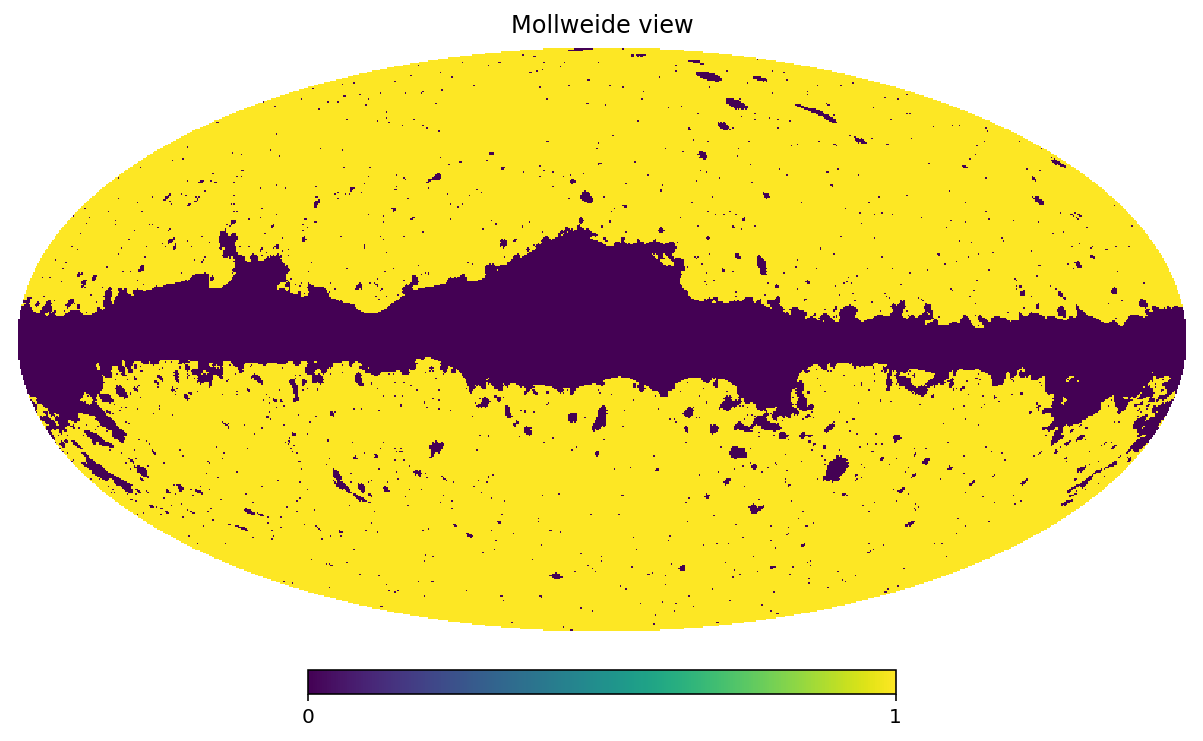

In [18]:
hp.mollview(mask)
plt.show()

In [19]:
# HEALPix resolution parameter used here
nside = 2048

In [20]:
# An NmtField object contains all the information describing the fields to correlate, including their observed maps, masks and contaminant templates.
f_0=nmt.NmtField(mask, [planck_IQU_SMICA])

In [21]:
# Initialize binning scheme with 4 ells per bandpower
# Convenience constructor for HEALPix maps with linear binning.
b = nmt.NmtBin.from_nside_linear(nside, 4)

In [22]:
# Compute MASTER estimator
# spin-0 x spin-0
#Computes the full MASTER estimate of the power spectrum of two fields (f1 and f2). 
cl_00 = nmt.compute_full_master(f_0, f_0, b)

In [23]:
# Shape of the pseudo Cls
cl_00.shape
cl_00[0]


array([2.17561436e-10, 7.35844194e-11, 3.20879069e-11, ...,
       1.28760109e-18, 1.37457963e-18, 1.56123462e-18])

In [24]:
#Returns an array with the effective multipole associated to each bandpower. 
#These are computed as a weighted average of the multipoles within each bandpower.
el = b.get_effective_ells()
el.shape
el



array([3.5000e+00, 7.5000e+00, 1.1500e+01, ..., 6.1315e+03, 6.1355e+03,
       6.1395e+03])

(0.0, 2500.0)

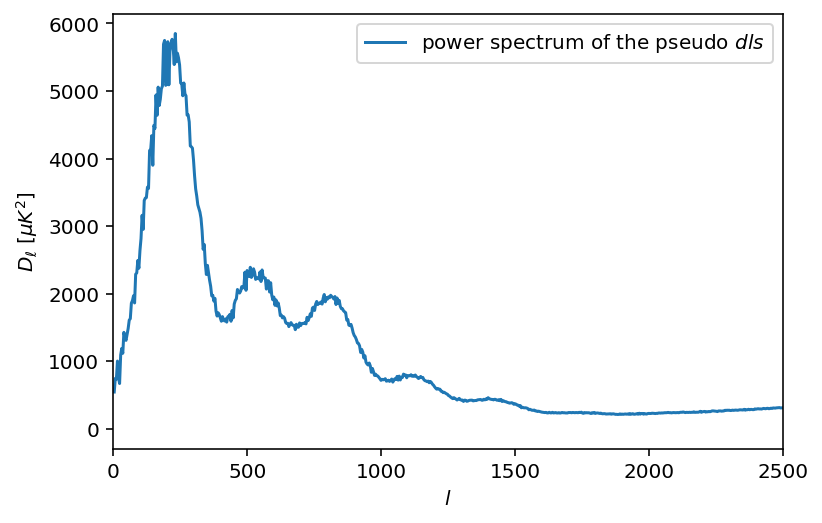

In [25]:
#plot results
dl=cl_00[0]*[(1e6)**(2)]*el*(el+1)/2/np.pi
plt.plot(el,dl, label='power spectrum of the pseudo $dls$')
plt.legend()
plt.xlabel(r'$l$')
plt.ylabel('$D_\ell~[\mu K^2]$')
plt.xlim(0,2500)

In [26]:
# Interpolation of the pseudo Dls
from scipy.interpolate import interp1d

In [27]:
# I define the interpolation with x**3
f=interp1d(el, dl, kind='cubic') 

In [28]:
# I define my news l
lnew=np.linspace(4, 2500, 2498)
# oncatenate

#pdl is the interpolation of the pseudo Dls
pdl_int=f(lnew)
lnew.shape

(2498,)

In [29]:
# Concatenate the ls
ljoin=np.concatenate((([0,0,2,3]),lnew))
# Concatenate the pseudo Dls
pDl_=np.concatenate((([0.0,0.0,203.36331868506028,918.9783866182479]),pdl_int ))


a. $ \textbf{I compute the correlation function $\zeta (\theta)$ of the pseudo $D_l$}$

In [30]:
# pDl_ is may new array
pDl_.shape

(2502,)

In [31]:
Dl=np.ones((len(pDl_),4))
Dl[:,0]=pDl_
Dl.shape

(2502, 4)

In [162]:
corr2, xvals_1, weights = correlations.gauss_legendre_correlation(Dl) 
#xvals2=np.linspace(-1,1,2502)
r2=np.arccos(xvals_1)*180/np.pi # sampled theta values in degrees

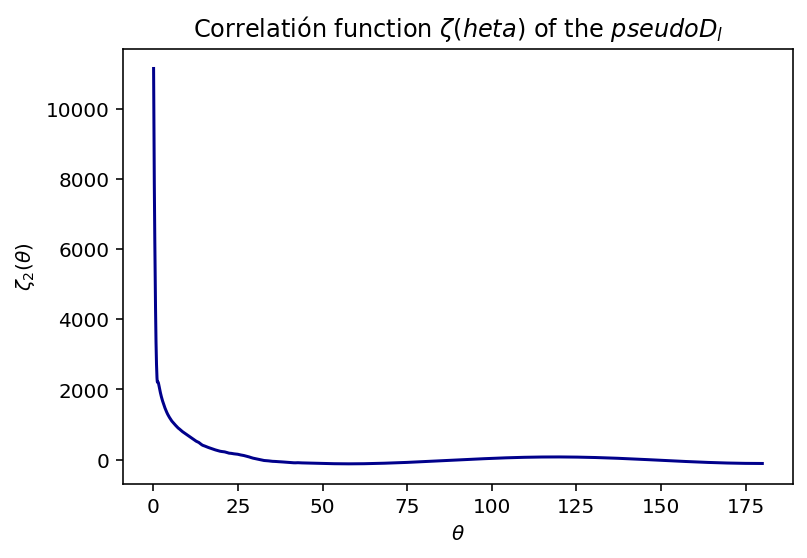

In [163]:
plt.plot(r2, corr2[:,0], color = 'darkblue')
plt.ylabel(r'$\zeta_{2}(\theta)$')
plt.xlabel(r'$\theta$')
plt.title('Correlatión function $\zeta (\theta)$ of the $pseudo D_{l}$')
plt.show()

4. $\textbf{In this section we are going to compute the errors. This will be done generating 100 cmb maps with theoretical $D_{ls}$ supplied by $\Lambda CDM$ throughout CAMB and Healpy python routine.}$

In [176]:
# Generating Nmaps cmb maps
Nmaps = 50
lmax  = 2500
nside = 2048

mapa_cl = np.zeros((Nmaps,50331648),np.float32)
for i in range(Nmaps):
    print("\rmapa #%d..."%i,end='')
    mapa_cl[i] = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
print("listo!")

MemoryError: Unable to allocate 9.38 GiB for an array with shape (50, 50331648) and data type float32

In [145]:
# Generating cls from maps through hp.anafast
cl = np.ones((Nmaps,lmax+1,4),np.float32)
for i in range(Nmaps):
    print('\rcl #%d...'%i,end='')
    cl[i,:,0] = hp.anafast(mapa_cl[i], lmax=lmax)
    

cl #49...

In [165]:
corr    = np.zeros((Nmaps,lmax+1,4),np.float32)
for i in range(Nmaps):
    print('\rcorr #%d...'%i)
    corr[i], xvals_2, weights = correlations.gauss_legendre_correlation(cl[i])
    print('')
ra = np.arccos(xvals_2)*180/np.pi

corr #0...

corr #1...

corr #2...

corr #3...

corr #4...

corr #5...

corr #6...

corr #7...

corr #8...

corr #9...

corr #10...

corr #11...

corr #12...

corr #13...

corr #14...

corr #15...

corr #16...

corr #17...

corr #18...

corr #19...

corr #20...

corr #21...

corr #22...

corr #23...

corr #24...

corr #25...

corr #26...

corr #27...

corr #28...

corr #29...

corr #30...

corr #31...

corr #32...

corr #33...

corr #34...

corr #35...

corr #36...

corr #37...

corr #38...

corr #39...

corr #40...

corr #41...

corr #42...

corr #43...

corr #44...

corr #45...

corr #46...

corr #47...

corr #48...

corr #49...



In [152]:
media = np.mean(corr,axis=0)
sigma = np.std(corr,axis=0)

(-1000.0, 5000.0)

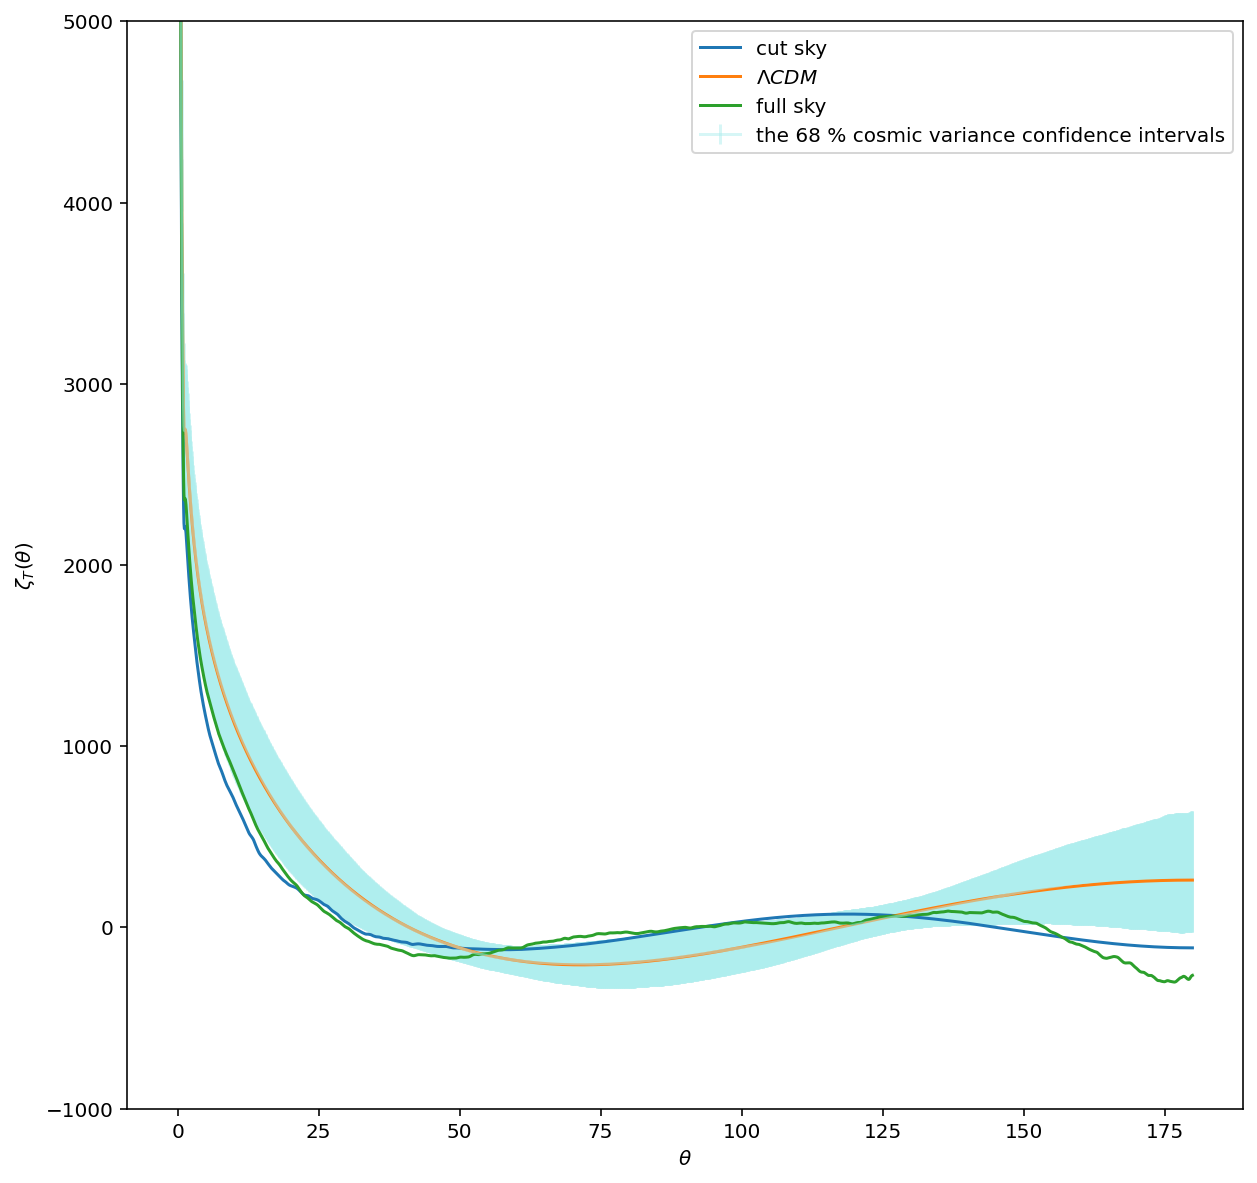

In [171]:
# Plotting the results
plt.figure(figsize=(10,10))
plt.errorbar(ra,media[:,0], yerr=sigma[:,0], color= 'paleturquoise', 
             label='the 68 % cosmic variance confidence intervals',alpha=0.5)
#for i in range(Nmaps):
    #plt.plot(r, corr[i,:,0],alpha=0.4)
#plt.plot(r, media[:,0],lw=2.,c='k')
plt.plot(r2, corr2[:,0], label = 'cut sky')
plt.plot(rk, corrs[:,0], label='$\Lambda CDM $')
plt.plot(r1, corr1[:,0], label ='full sky')
#plt.plot(r2_1, corr2_1[:,0], label = 'cut sky')
plt.ylabel(r'$\zeta_{T}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend(loc='best')

plt.ylim(-1000,5000)

 5. $\textbf{In this section we are downloanding cmb's mask from https://lambda.gsfc.nasa.gov/product/wmap/dr5/masks_info.html.\\
 a. We use the wmap_temperature_kq75_analysis_mask_r9_9yr_v5 mask. }$

In [67]:
# mask with nside=512 and resolution 9
mask_1=hp.read_map('/home/augusto/cmblss/data/wmap_temperature_kq75_analysis_mask_r9_9yr_v5.fits')

In [68]:
# Return the nside of a map
hp.get_nside(mask_1)

512

In [69]:
# Resolution of the mask
hp.nside2order(512)

9

In [70]:
# Resolution of the map
hp.get_nside(planck_IQU_SMICA)

2048

In [71]:
hp.nside2order(2048)

11

In [76]:
# Degrade the map
map_smica= hp.pixelfunc.ud_grade(planck_IQU_SMICA, 256)

In [77]:
# Degrade the mask
mask_1=hp.pixelfunc.ud_grade(mask_1,256)

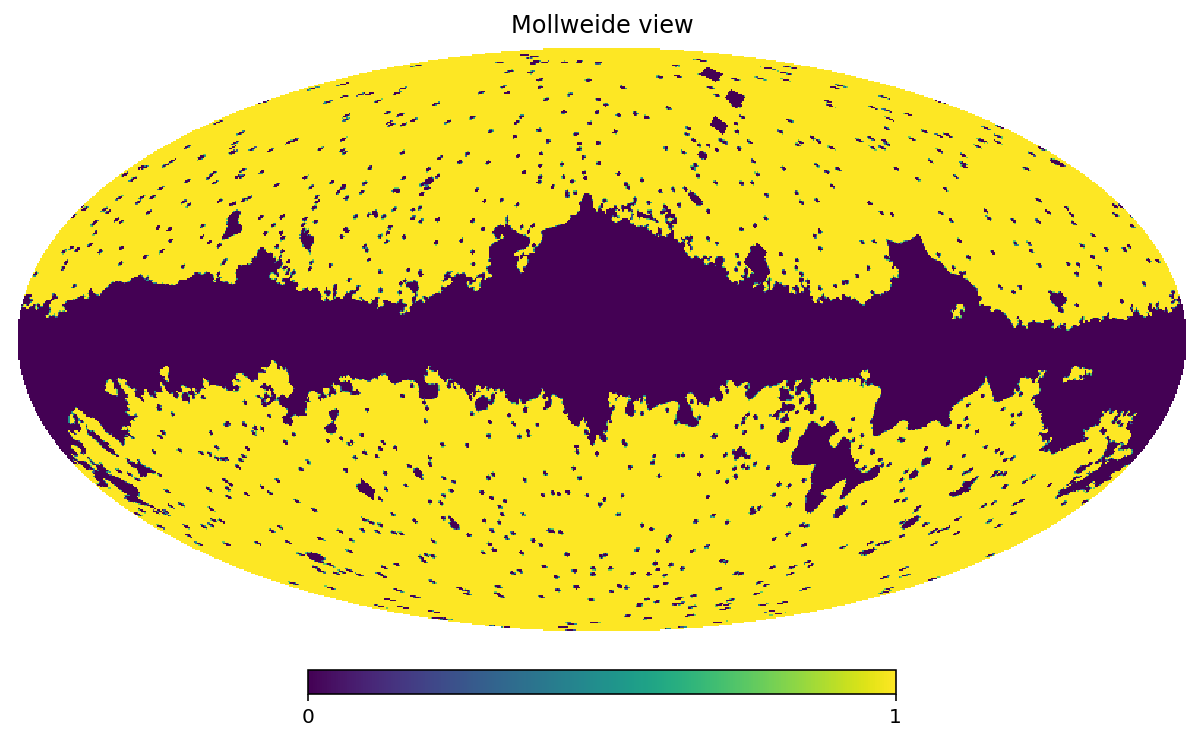

In [78]:
hp.mollview(mask_1)
plt.show()

In [79]:
# HEALPix resolution parameter used here
nside = 256

In [80]:
# An NmtField object contains all the information describing the fields to correlate, including their observed maps, masks and contaminant templates.
t_0=nmt.NmtField(mask_1, [map_smica])

In [81]:
# Initialize binning scheme with 4 ells per bandpower
# Convenience constructor for HEALPix maps with linear binning.
b_1 = nmt.NmtBin.from_nside_linear(nside, 4)

In [82]:
# Compute MASTER estimator
# spin-0 x spin-0
#Computes the full MASTER estimate of the power spectrum of two fields (f1 and f2). 
cl_10 = nmt.compute_full_master(t_0, t_0, b_1)

In [83]:
cl_10.shape 

(1, 191)

In [84]:
#Returns an array with the effective multipole associated to each bandpower. 
#These are computed as a weighted average of the multipoles within each bandpower.
el_1 = b_1.get_effective_ells()
el_1.shape
#el_1


(191,)

(0.0, 2500.0)

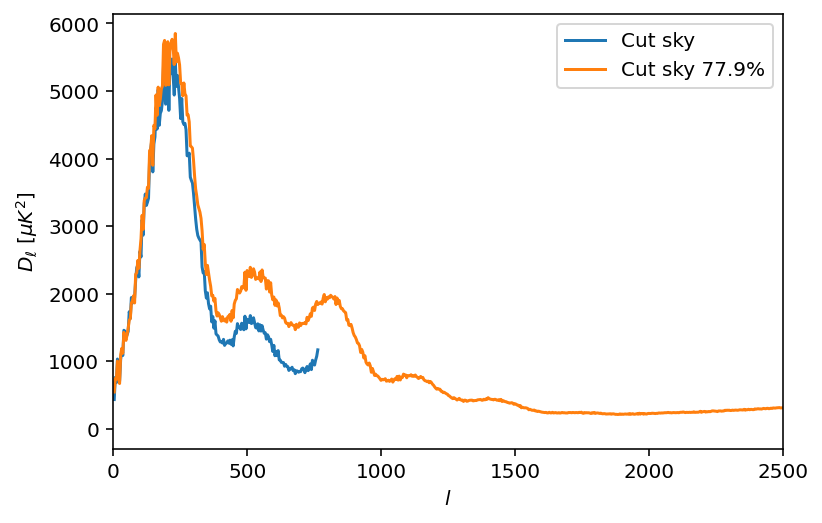

In [85]:
#plot results
d1l=cl_10[0]*[(1e6)**(2)]*el_1*(el_1+1)/2/np.pi
plt.plot(el_1, d1l, label ='Cut sky ')
plt.plot(el,dl, label='Cut sky 77.9%')
plt.legend()
plt.xlabel(r'$l$')
plt.ylabel('$D_\ell~[\mu K^2]$')
plt.xlim(0,2500)

In [121]:
# Interpolation of the pseudo Dls
# I define the interpolation with x**3
f1=interp1d(el_1, d1l, kind='cubic') 

In [122]:
# I define my news l
lnew1=np.linspace(4, 195, 191)
# oncatenate

#pdl is the interpolation of the pseudo Dls
pdl_int1=f1(lnew1)
lnew1.shape

(191,)

In [127]:
# Concatenate the ls
ljoin1=np.concatenate((([0,0,2,3]),lnew1))
# Concatenate the pseudo Dls
pDl_1=np.concatenate((([0.0,0.0,203.36331868506028,918.9783866182479]),pdl_int1 ))


In [128]:
# Make the array to input in the correlation function
D1l=np.zeros((len(pDl_1),4))

In [129]:
D1l.shape

(195, 4)

In [130]:
D1l[:,0]=pDl_1

In [171]:
corr3, xvals3, weights = correlations.gauss_legendre_correlation(D1l) 
xvals3=np.linspace(-1,1,195)
r3=np.arccos(xvals3)*180/np.pi # sampled theta values in degrees

(-1000.0, 4000.0)

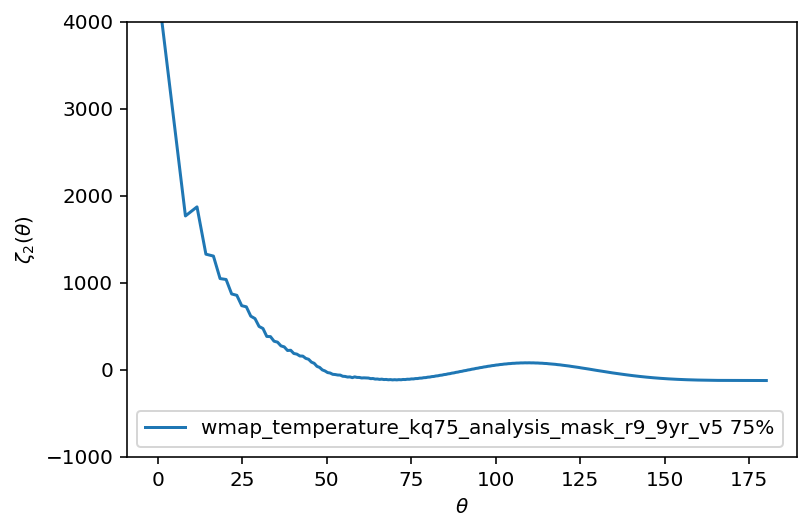

In [172]:
# Plol the results
plt.plot(r3, corr3[:,0], label = 'wmap_temperature_kq75_analysis_mask_r9_9yr_v5 75%')
plt.ylabel(r'$\zeta_{2}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend(loc='best')
plt.ylim(-1000,4000)

b. $\textbf{ We use the wmap_temperature_kq85_analysis_mask_r9_9yr_v5.fits
mask.\\}$

In [101]:
# Read the mask
mask_2=hp.read_map('/home/augusto/cmblss/data/wmap_temperature_kq85_analysis_mask_r9_9yr_v5.fits')

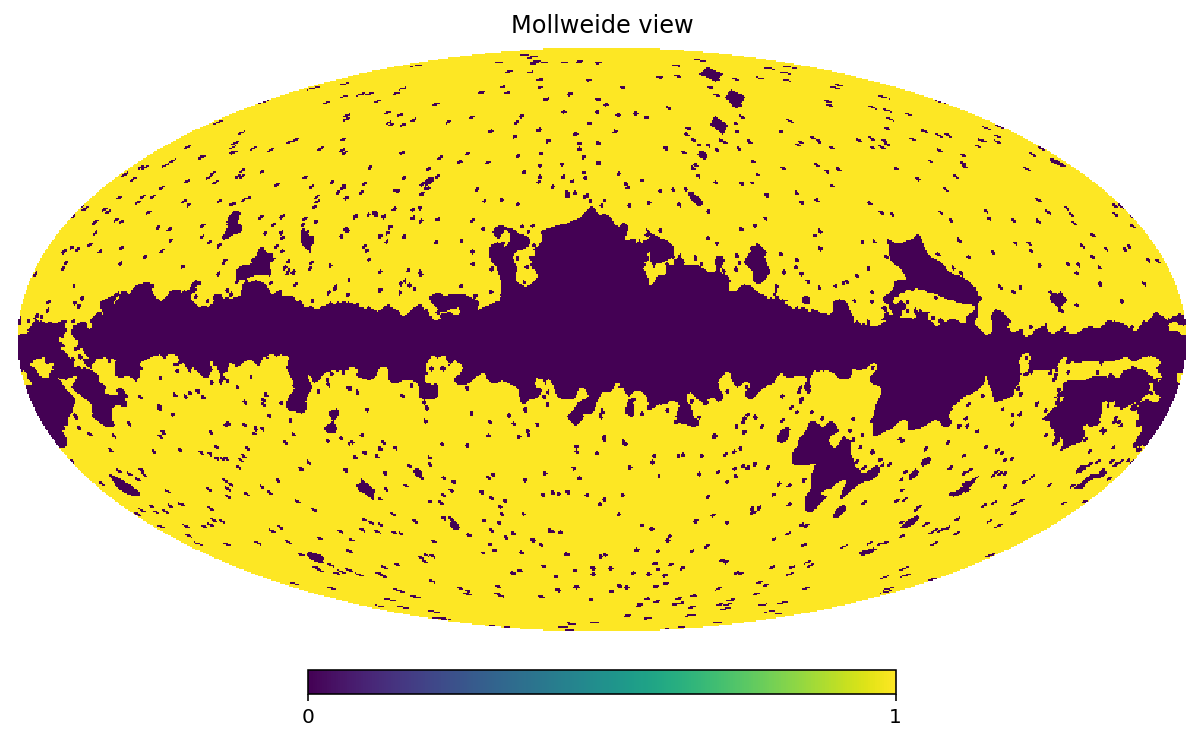

In [102]:
hp.mollview(mask_2)
plt.show()

In [103]:
# Resolution 
hp.get_nside(mask_2)

512

In [104]:
# Degrade the mask  until nside=256
mask_2=hp.pixelfunc.ud_grade(mask_2,256)

In [105]:
# HEALPix resolution parameter used here
nside = 256

In [106]:
# An NmtField object contains all the information describing the fields to correlate, including their observed maps, masks and contaminant templates.
t_2=nmt.NmtField(mask_2, [map_smica])

In [107]:
# Initialize binning scheme with 4 ells per bandpower
# Convenience constructor for HEALPix maps with linear binning.
b_2= nmt.NmtBin.from_nside_linear(nside, 4)

In [108]:
# Compute MASTER estimator
# spin-0 x spin-0
#Computes the full MASTER estimate of the power spectrum of two fields (f1 and f2). 
cl_20 = nmt.compute_full_master(t_2, t_2, b_2)

In [110]:
#Returns an array with the effective multipole associated to each bandpower. 
#These are computed as a weighted average of the multipoles within each bandpower.
el_2 = b_2.get_effective_ells()
el_2.shape


(191,)

In [111]:
# The Dls
d2l=cl_20[0]*[(1e6)**(2)]*el_2*(el_2+1)/2/np.pi

In [113]:
# Interpolation of the pseudo Dls
# I define the interpolation with x**3
f2=interp1d(el_2, d2l, kind='cubic') 

In [114]:
# I define my news l
lnew2=np.linspace(4, 195, 191)
# oncatenate

#pdl is the interpolation of the pseudo Dls
pdl_int2=f2(lnew2)
lnew2.shape

(191,)

In [115]:
# Concatenate the ls
ljoin2=np.concatenate((([0,0,2,3]),lnew2))
# Concatenate the pseudo Dls
pDl_2=np.concatenate((([0.0,0.0,203.36331868506028,918.9783866182479]),pdl_int2 ))

In [116]:
# computing the correlation function
D2l=np.ones((len(pDl_2),4))
D2l[:,0]=pDl_2
D2l.shape

(195, 4)

In [173]:
corr4, xvals4, weights = correlations.gauss_legendre_correlation(D2l) 
xvals4=np.linspace(-1,1,195)
r4=np.arccos(xvals4)*180/np.pi # sampled theta values in degrees

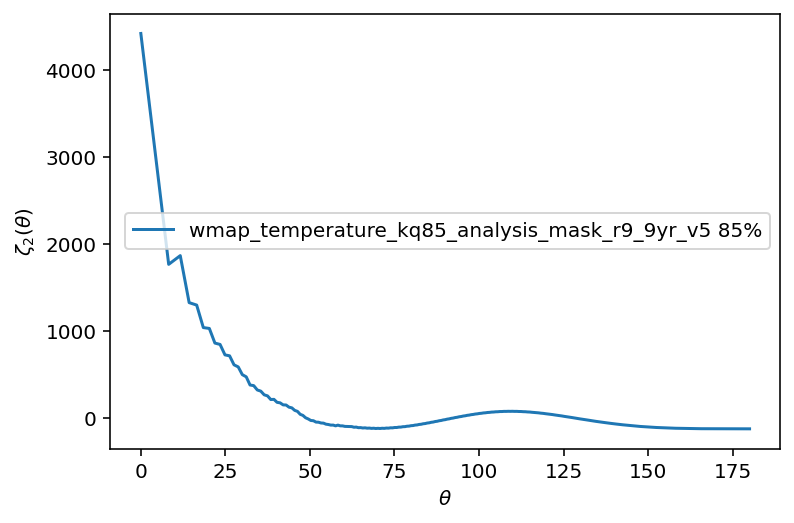

In [175]:
plt.plot(r4, corr4[:,0], label = 'wmap_temperature_kq85_analysis_mask_r9_9yr_v5 85%')
plt.ylabel(r'$\zeta_{2}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend(loc='best')

c. $\textbf{ We use the wmap_kp8_mask_r9_9yr_v5.fits
mask.\\}$

In [134]:
# Read the mask
mask_3=hp.read_map('/home/augusto/cmblss/data/wmap_kp8_mask_r9_9yr_v5.fits')

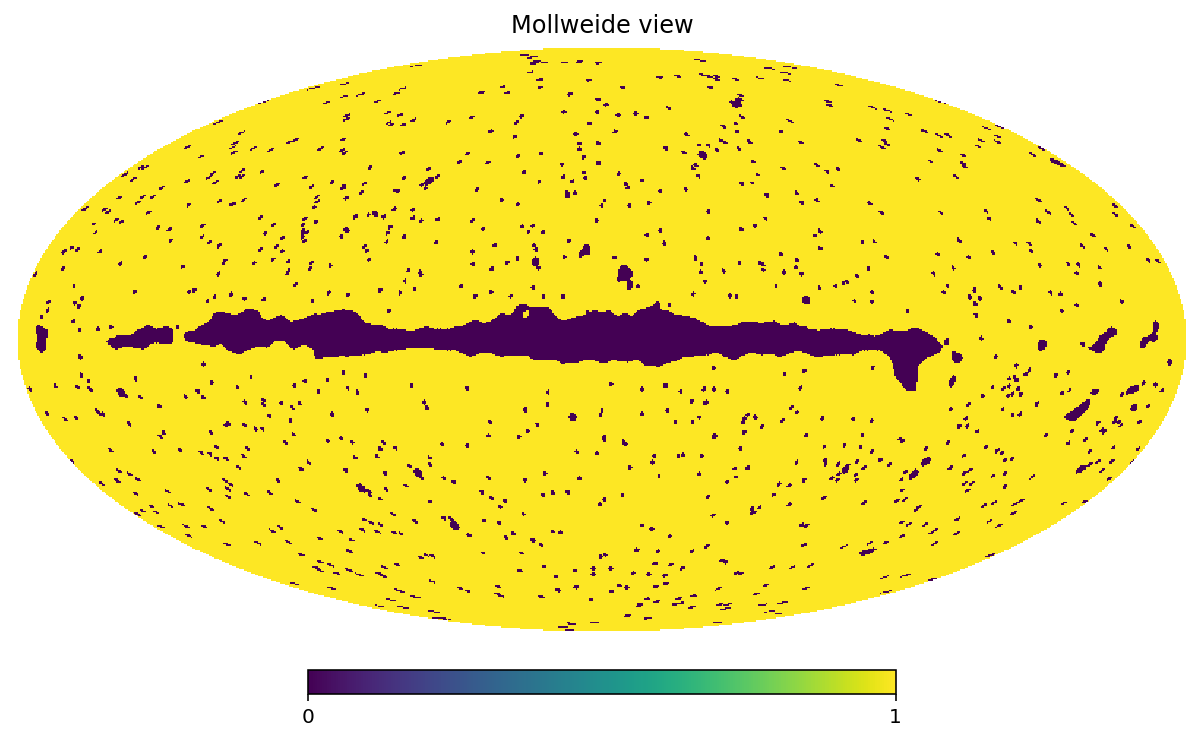

In [135]:
hp.mollview(mask_3)
plt.show()

In [136]:
# Resolution 
hp.get_nside(mask_3)

512

In [137]:
# Degrade the mask  until nside=256
mask_3=hp.pixelfunc.ud_grade(mask_3,256)

In [138]:
# HEALPix resolution parameter used here
nside = 256

In [139]:
# An NmtField object contains all the information describing the fields to correlate, including their observed maps, masks and contaminant templates.
t_3=nmt.NmtField(mask_3, [map_smica])

In [140]:
# Initialize binning scheme with 4 ells per bandpower
# Convenience constructor for HEALPix maps with linear binning.
b_3= nmt.NmtBin.from_nside_linear(nside, 4)

In [141]:
# Compute MASTER estimator
# spin-0 x spin-0
#Computes the full MASTER estimate of the power spectrum of two fields (f1 and f2). 
cl_30 = nmt.compute_full_master(t_3, t_3, b_3)

In [142]:
#Returns an array with the effective multipole associated to each bandpower. 
#These are computed as a weighted average of the multipoles within each bandpower.
el_3 = b_3.get_effective_ells()
el_3.shape


(191,)

In [143]:
# The Dls
d3l=cl_30[0]*[(1e6)**(2)]*el_3*(el_3+1)/2/np.pi

In [144]:
# Interpolation of the pseudo Dls
# I define the interpolation with x**3
f3=interp1d(el_3, d3l, kind='cubic') 

In [145]:
# I define my news l
lnew3=np.linspace(4, 195, 191)
# oncatenate

#pdl is the interpolation of the pseudo Dls
pdl_int3=f3(lnew3)
lnew3.shape

(191,)

In [146]:
# Concatenate the ls
ljoin3=np.concatenate((([0,0,2,3]),lnew3))
# Concatenate the pseudo Dls
pDl_3=np.concatenate((([0.0,0.0,203.36331868506028,918.9783866182479]),pdl_int3 ))

In [147]:
# Make un array to compute the correlation function

D3l=np.ones((len(pDl_3),4))
D3l[:,0]=pDl_3
D3l.shape

(195, 4)

In [177]:
# Computing the correlation function
corr5, xvals5, weights = correlations.gauss_legendre_correlation(D3l) 
xvals5=np.linspace(-1,1,195)
r5=np.arccos(xvals5)*180/np.pi # sampled theta values in degrees

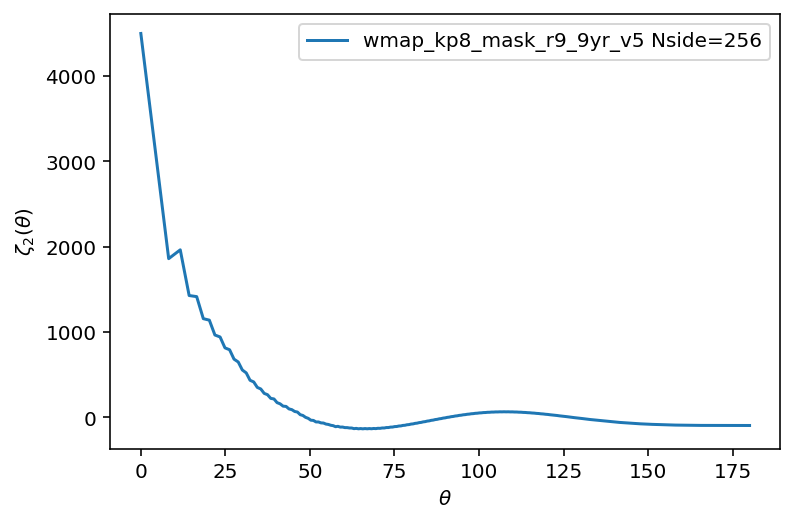

In [178]:
plt.plot(r5, corr5[:,0], label = 'wmap_kp8_mask_r9_9yr_v5 Nside=256')
plt.ylabel(r'$\zeta_{2}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend(loc='best')

(-450.0, 1000.0)

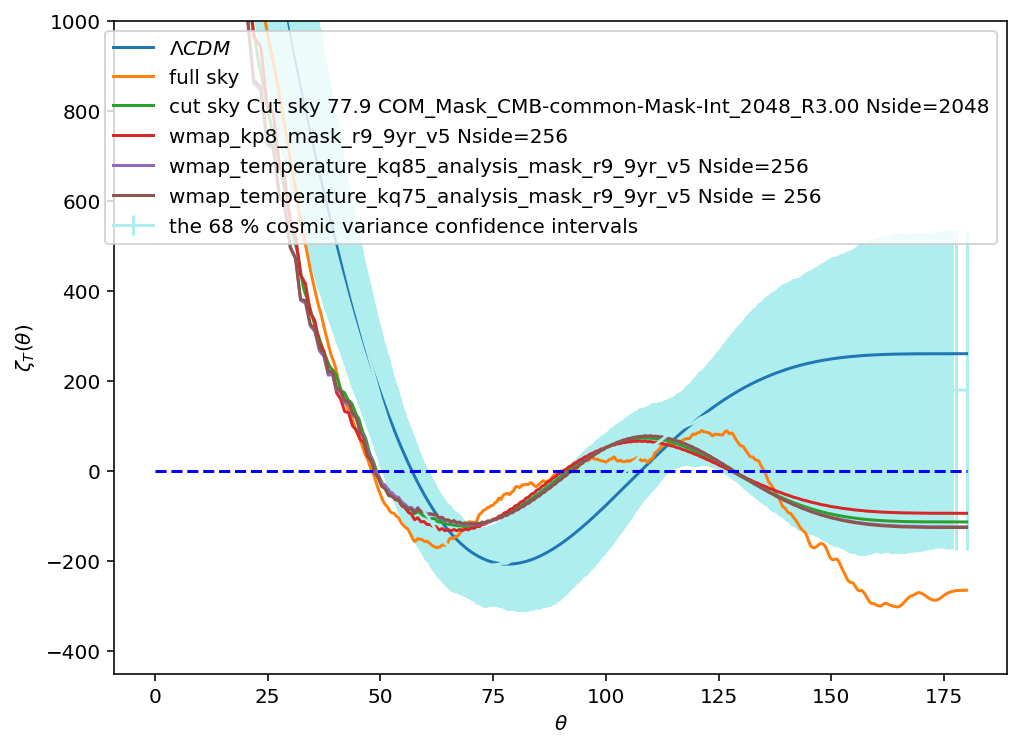

In [194]:
# Put the correlation function all together
plt.figure(figsize=(8,6)) # Plot size

#Error bars
plt.errorbar(r_1,media, yerr=sigma, color= 'paleturquoise', label='the 68 % cosmic variance confidence intervals')

# Plotting the correlation function
plt.plot(r, corrs[:,0], label='$\Lambda CDM $')
plt.plot(r1, corr1[:,0], label ='full sky')
plt.plot(r2, corr2[:,0], label = 'cut sky Cut sky 77.9 COM_Mask_CMB-common-Mask-Int_2048_R3.00 Nside=2048')
plt.plot(r5, corr5[:,0], label = 'wmap_kp8_mask_r9_9yr_v5 Nside=256')
plt.plot(r4, corr4[:,0], label = 'wmap_temperature_kq85_analysis_mask_r9_9yr_v5 Nside=256')
plt.plot(r3, corr3[:,0], label = 'wmap_temperature_kq75_analysis_mask_r9_9yr_v5 Nside = 256')

# Horizontal bar at y = 0.0

plt.hlines(y=0.0, xmin=0.0, xmax=180.0, color='b', linestyles='dashed')


plt.ylabel(r'$\zeta_{T}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend()

plt.ylim(-450,1000)


In [142]:
# Interpolations
# I define the interpolation with x**3
f_1=interp1d(el_1, d1l, kind='cubic') 
f_2=interp1d(el_2, d2l, kind ='cubic')
f_3=interp1d(el_3, d3l, kind= 'cubic')

In [143]:
# I define my news l
lnew_1=np.linspace(4, 195, 191)
lnew_2=np.linspace(4, 195, 191)
lnew_3=np.linspace(4, 195, 191)

#pdl is the interpolated new function 
pdl_1=f_1(lnew_1)
pdl_2=f_1(lnew_2)
pdl_3=f_1(lnew_3)
lnew_3.shape

(191,)

In [144]:
# DL are arrays to compute the correlation function
DL_1=np.zeros((len(pdl_1),4))
DL_1[:,0]=pdl_1
DL_2=np.zeros((len(pdl_2),4))
DL_2[:,0]=pdl_2
DL_3=np.zeros((len(pdl_3),4))
DL_3[:,0]=pdl_3
DL_3.shape

(191, 4)

In [145]:
# Compute the correlation function

c_1, xvals, weights = correlations.gauss_legendre_correlation(DL_1)
c_2, xvals, weights = correlations.gauss_legendre_correlation(DL_2)
c_3, xvals, weights = correlations.gauss_legendre_correlation(DL_3)
xvals_=np.linspace(-1,1,191)
r_=np.arccos(xvals_)*180/np.pi # sampled theta values in degrees


(-400.0, 5000.0)

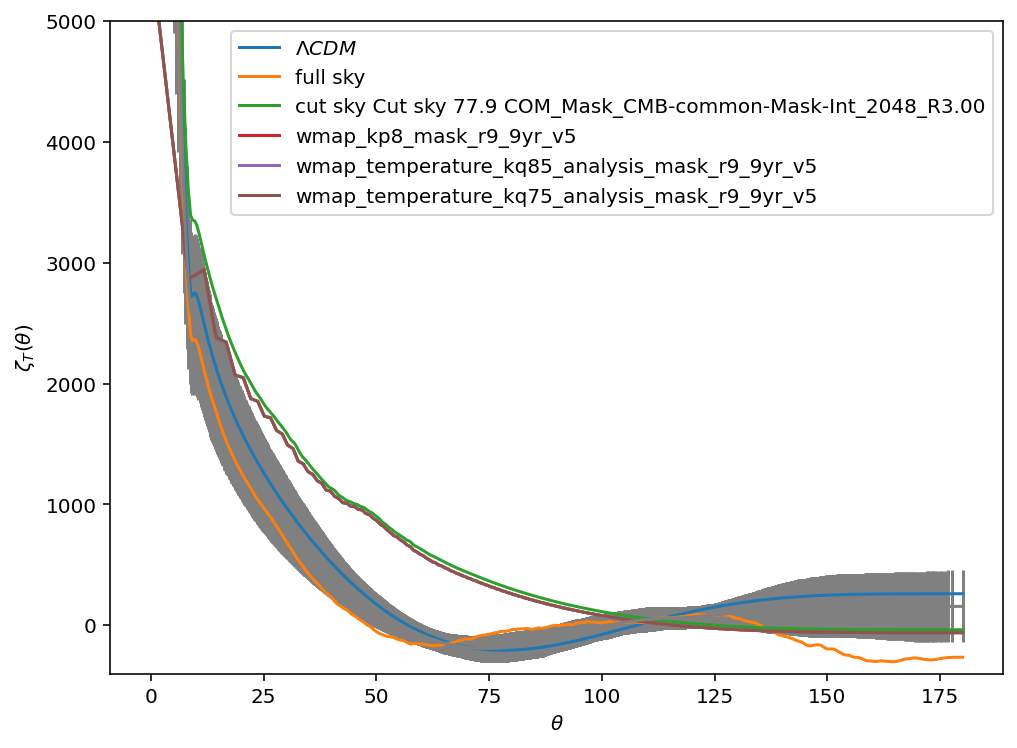

In [146]:
# Put the correlation function all together
plt.figure(figsize=(8,6)) # Plot size
plt.errorbar(r_1,media, yerr=sigma, color= 'grey')
plt.plot(r, corrs[:,0], label='$\Lambda CDM $')
plt.plot(r1, corr1[:,0], label ='full sky')
plt.plot(r2_1, corr2_1[:,0], label = 'cut sky Cut sky 77.9 COM_Mask_CMB-common-Mask-Int_2048_R3.00')
plt.plot(r_, c_3[:,0], label = 'wmap_kp8_mask_r9_9yr_v5')
plt.plot(r_, c_2[:,0], label = 'wmap_temperature_kq85_analysis_mask_r9_9yr_v5')
plt.plot(r_, c_1[:,0], label = 'wmap_temperature_kq75_analysis_mask_r9_9yr_v5')

plt.ylabel(r'$\zeta_{T}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend(loc='best')

plt.ylim(-400,5000)
